#Jak budować modele prognozowania popytu za pomocą BigQuery ML (YT + Blog)

* https://www.youtube.com/watch?v=dwOt68CevYA

* https://cloud.google.com/blog/topics/developers-practitioners/how-build-demand-forecasting-models-bigquery-ml




##Dane: Sprzedaż alkoholu w stanie Iowa (Krok 1)

In [ ]:
%%bigquery

SELECT
    invoice_and_item_number,
    date,
    store_number,
    item_description,
    bottles_sold,
    sale_dollars
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
LIMIT
  5

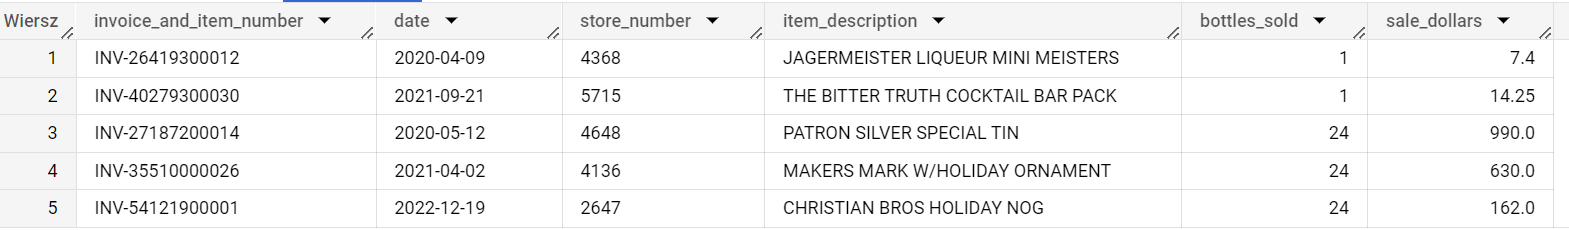

##Wyczyszczone dane treningowe (Krok 2)

* W wyczyszczonych danych szkoleniowych mamy teraz po jednym wierszu na `date i item_name`, czyli całkowitą kwotę sprzedaną tego dnia. Można to zapisać jako tabelę lub widok.

In [ ]:
%%bigquery

create or replace table `pmackowka_us.table_0191` as (

SELECT
        date,
        item_description AS item_name,
        SUM(bottles_sold) AS total_amount_sold
    FROM
        `bigquery-public-data.iowa_liquor_sales.sales`
    GROUP BY
        date, item_name
    HAVING
        date BETWEEN DATE('2016-01-01') AND DATE('2017-01-01')

)

##Trenuj model szeregów czasowych za pomocą BigQuery ML (Krok 3)

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL pmackowka_us.model_0191

OPTIONS(
  MODEL_TYPE='ARIMA_PLUS',
  TIME_SERIES_TIMESTAMP_COL='date',
  TIME_SERIES_DATA_COL='total_amount_sold',
  TIME_SERIES_ID_COL='item_name', # Prognoza wielu wymiarów
  HOLIDAY_REGION='US'
) AS

SELECT
    date,
    item_name,
    total_amount_sold
FROM
  `prj-ecom-p-ad-server-1077.pmackowka_us.table_0191`

* Proces ML:

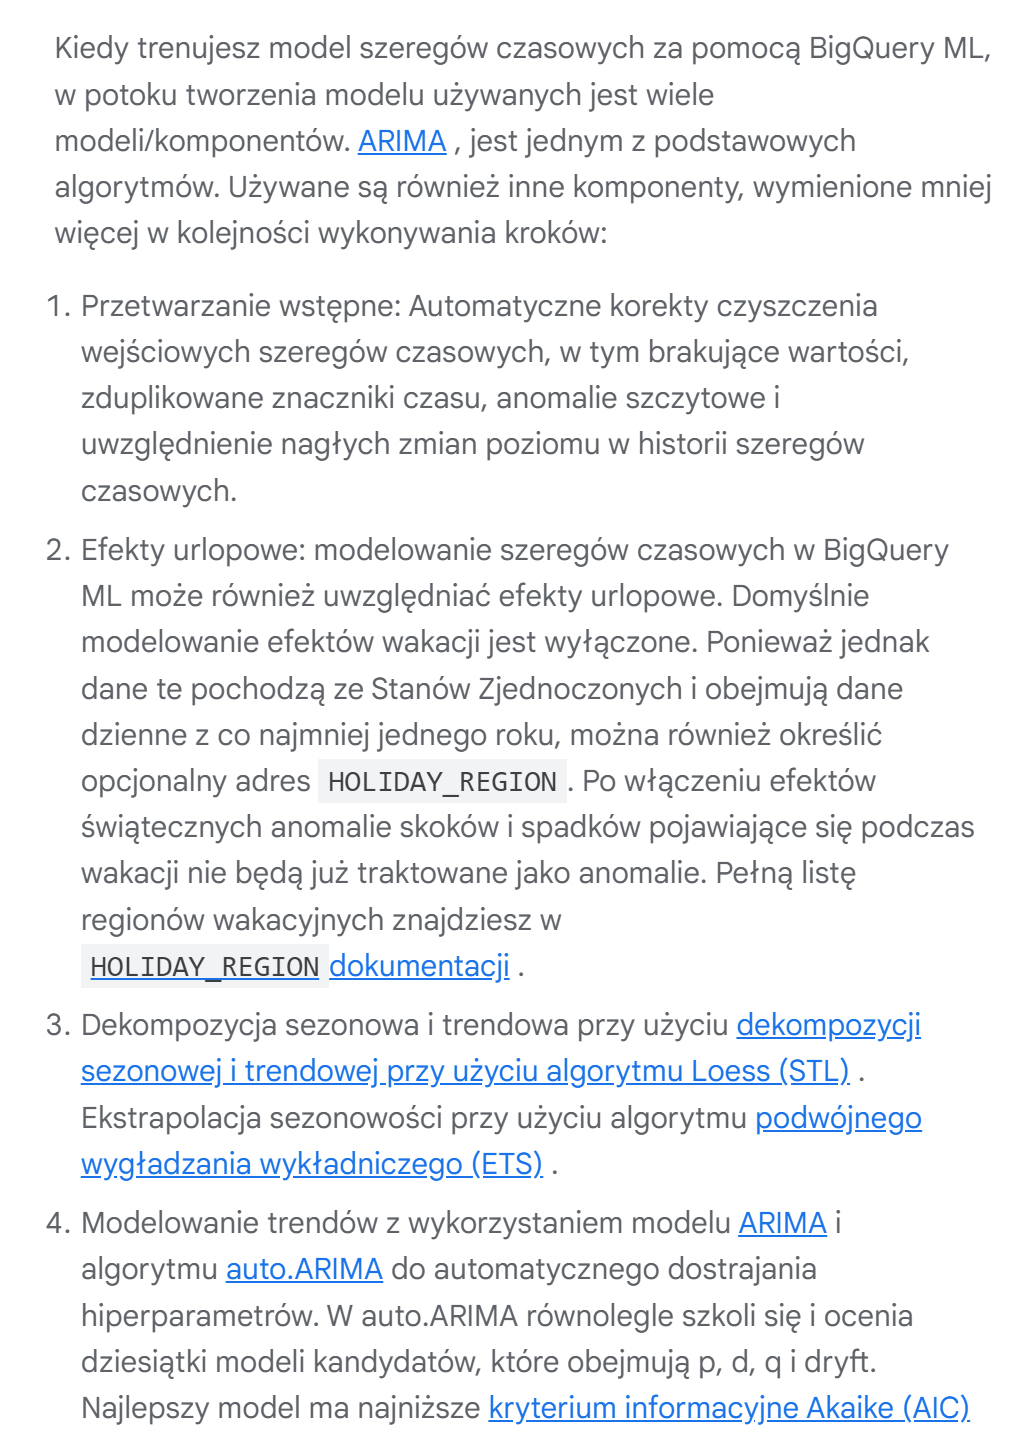

##Oceń model szeregów czasowych (Krok 4)

###ML.EVALUATE

In [ ]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE(MODEL pmackowka_us.model_0191)

order by item_name, AIC asc

##Przewiduj, korzystając z modelu (Krok 5)

###ML.FORECAST

In [ ]:
%%bigquery

DECLARE HORIZON STRING DEFAULT "30"; # number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90";

EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM
      ML.FORECAST(MODEL pmackowka_us.model_0191,
                  STRUCT(%s AS horizon,
                         %s AS confidence_level)
                 )
    """, HORIZON, CONFIDENCE_LEVEL)

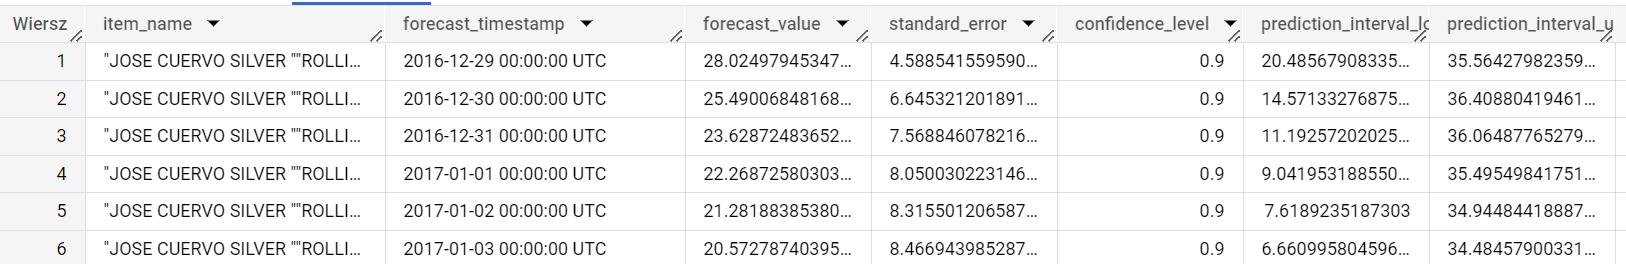

##W jaki sposób regularnie automatycznie i ponownie szkolisz model? (Krok 6)

* Trzeba tworzyć świeże prognozy szeregów czasowych w oparciu o najnowsze dane, możesz użyć zaplanowanych zapytań, aby automatycznie uruchomić zapytania SQL, które obejmują zapytania `CREATE MODEL, ML.EVALUATE lub ML.FORECAST`

###1. Utwórz nowe zaplanowane zapytanie w interfejsie BigQuery

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL pmackowka_us.model_0191

OPTIONS(
  MODEL_TYPE='ARIMA_PLUS',
  TIME_SERIES_TIMESTAMP_COL='date',
  TIME_SERIES_DATA_COL='total_amount_sold',
  TIME_SERIES_ID_COL='item_name', # Prognoza wielu wymiarów
  HOLIDAY_REGION='US'
) AS

SELECT
    date,
    item_name,
    total_amount_sold
FROM
  `prj-ecom-p-ad-server-1077.pmackowka_us.table_0191`

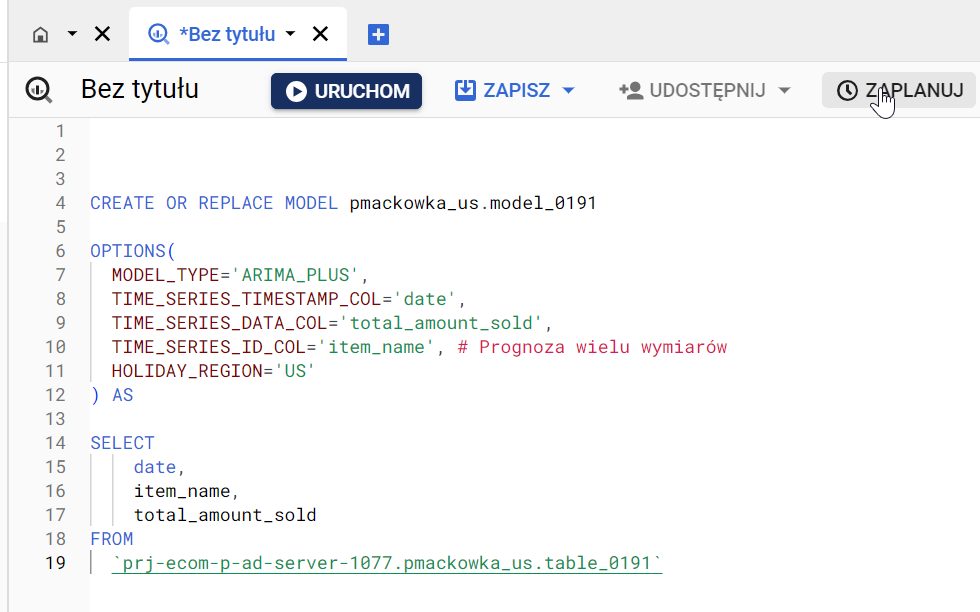

###2. Wprowadź swoje wymagania (np. powtarzanie co tydzień) i wybierz „Harmonogram”

##Dodatkowe wskazówki dotyczące używania szeregów czasowych w BigQuery ML (Krok 7)

* Sprawdź współczynniki modelu ARIMA

In [ ]:
%%bigquery

SELECT
  *
FROM
  ML.ARIMA_COEFFICIENTS(MODEL pmackowka_us.model_0191)

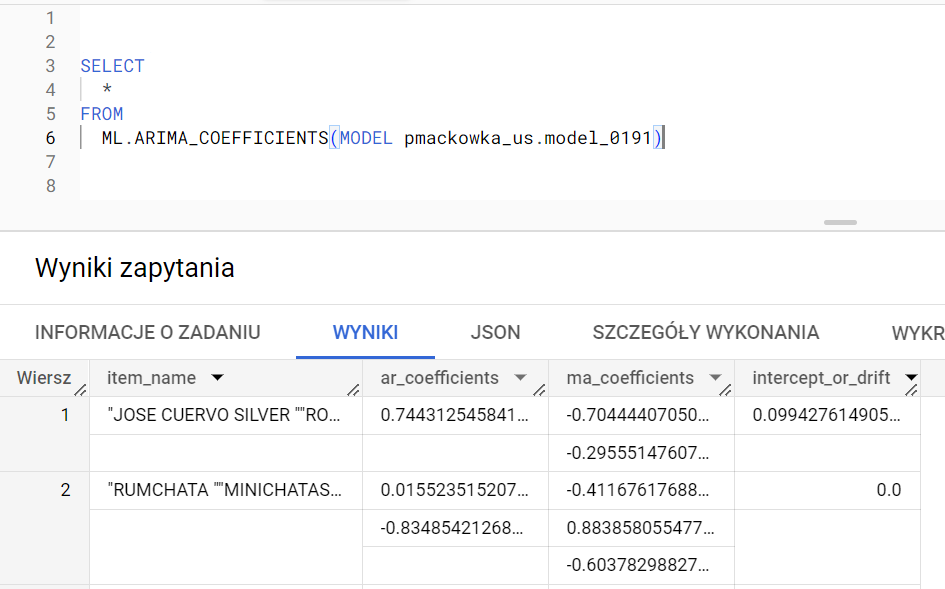

#Jak budować modele prognozowania popytu za pomocą BigQuery ML (Github)

* https://github.com/GoogleCloudPlatform/analytics-componentized-patterns/blob/master/retail/time-series/bqml-demand-forecasting/bqml_retail_demand_forecasting.ipynb